In [13]:
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
import seaborn as sns
from torchmetrics import MetricCollection, classification
from scipy.stats import friedmanchisquare

from Modules import PyTorch_Training, Fingerprint_Generator, Misc_Utils, Fingerprint_Comparator

In [14]:
torch.manual_seed(42)

df_train = pd.read_csv('Transformed_Data/rega_train.csv')
df_test = pd.read_csv('Transformed_Data/rega_test.csv')

print(df_train.head(2))

              smiles  label
0  CN(C)C(=N)N=C(N)N      0
1   COC(=O)C=CC(=O)O      0


In [15]:
# Set the device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device: {torch.cuda.get_device_name(0)}")

DILI_model = PyTorch_Training.DILI_Models.DILI_Predictor_Sequential(2048, 512, 1).to(device)

Using cuda device: NVIDIA GeForce GTX 1070


In [16]:
metric_collection = MetricCollection([
    classification.Accuracy(task='binary', average='macro'),  # Balanced accuracy
    classification.BinaryAUROC(),
    classification.BinaryMatthewsCorrCoef(),
    classification.BinaryPrecision(),
    classification.BinaryF1Score(),
    classification.BinarySpecificity(),
    classification.BinaryJaccardIndex(),
    ]).to(device)

In [17]:
regular_fingerprints = Fingerprint_Generator.Fingerprint_Types().regular_fingerprints(abridged_set=True)

comparator = Fingerprint_Comparator.Pytorch_Train(df_train.iloc[:,0], df_train.iloc[:,1], DILI_model, 2048, metric_collection)

comparator_results, comparator_results_multiindex = comparator.regular_fingerprint(regular_fingerprints, k_folds=3, epochs=2)

comparator_results.reset_index(inplace=True)


-------------------------------------------------------------maccs-------------------------------------------------------------
Fold 1 final results after 2 epochs: Train Acc: 0.037 Train Loss: 0.691 (n = 1562) | Test Acc: 0.126 Test Loss: 0.693 (n = 782) 
Fold 2 final results after 2 epochs: Train Acc: 0.210 Train Loss: 0.690 (n = 1563) | Test Acc: 0.846 Test Loss: 0.687 (n = 781) 
Fold 3 final results after 2 epochs: Train Acc: 1.000 Train Loss: 0.695 (n = 1563) | Test Acc: 1.000 Test Loss: 0.697 (n = 781) 
-------------------------------------------------------------ecfp--------------------------------------------------------------
Fold 1 final results after 2 epochs: Train Acc: 0.403 Train Loss: 0.677 (n = 1562) | Test Acc: 0.487 Test Loss: 0.678 (n = 782) 
Fold 2 final results after 2 epochs: Train Acc: 0.293 Train Loss: 0.684 (n = 1563) | Test Acc: 0.731 Test Loss: 0.684 (n = 781) 
Fold 3 final results after 2 epochs: Train Acc: 0.548 Train Loss: 0.684 (n = 1563) | Test Acc: 0.36

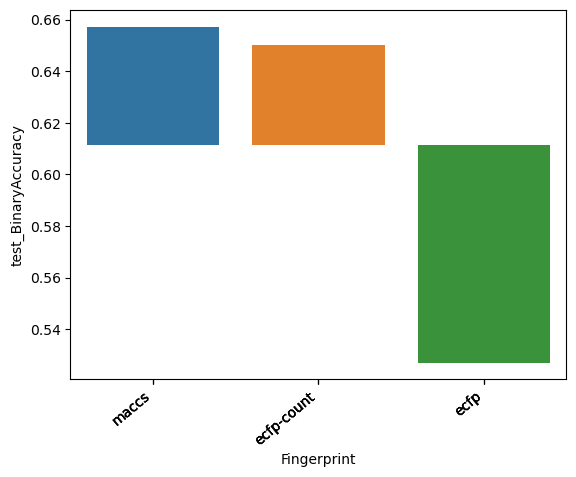

In [21]:
mean_comparator_output, mean_score = Misc_Utils.get_average_score(comparator_results, "test_BinaryAccuracy", "Fingerprint", normalize_scores=True)

# comparator_results_means = comparator_results.iloc[:,2] - mean_score
# comparator_results_means = comparator_results_means.sort_values(ascending=False)
fp_plot = sns.barplot(
    data = mean_comparator_output,
    x='Fingerprint',
    y='test_BinaryAccuracy',
    hue="Fingerprint",
    errorbar=None,
    bottom=mean_score,
)


# The semicolons at the line end stop Seaborn printing a dataframe
fp_plot.xaxis.set_ticks(comparator_results["Fingerprint"])
# Prevent Seaborn error if x-axis ticks not explicitly defined before the next line is run
fp_plot.set_xticklabels(fp_plot.get_xticklabels(), rotation=40, ha="right");  # Rotate X-axis labels

In [10]:
list_of_scores = []

for fingerprint in regular_fingerprints:
    fp_and_acc = comparator_results.filter(["Fingerprint", "test_BinaryAccuracy"], axis=1)
    fp_and_acc = (fp_and_acc.query('Fingerprint == @fingerprint'))
    list_of_scores.append(fp_and_acc)


friedman_stat, friedman_p = friedmanchisquare(*[list_of_scores[x].iloc[:, 1] for x in range(len(list_of_scores))])
print(friedman_p)

0.09697196786440515


In [9]:
import matplotlib.pyplot as plt


def plot_loss_curve(results: dict[str, list[float]]):
    train_loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Plot loss
    plt.figure(figsize=(10, 6))
    
    plt.plot(train_loss, label="train_loss")
    plt.plot(test_loss, label="test_loss")
    
    plt.title("Loss vs Epochs")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curve(model0_loss)

NameError: name 'model0_loss' is not defined

In [ ]:
# from Modules import My_Pytorch_Utilities

# dummy_data = torch.rand([1, 2048])

# dummy_data.shape

# My_Pytorch_Utilities.save(model0, "DILIst", dummy_data.to(device))